In [104]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

## Load Data

In [105]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd

# Update this path to match your actual file location in Drive
file_path = '/content/drive/MyDrive/Bayes/data_processed-v3.csv'

df = pd.read_csv(file_path)
#df = df.drop(columns=["Unnamed: 0"])  # drop extra index column
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,gender,age_group,hypertension,heart_disease,ever_married,work_type,Residence_type,smoking_status,stroke,glucose_level_group,bmi_group
0,Male,Old,hypertension_No,heart_disease_Yes,Yes,Work,Urban,formerly smoked,stroke_Yes,High,Obese
1,Male,Old,hypertension_No,heart_disease_Yes,Yes,Work,Rural,never smoked,stroke_Yes,Low,Obese
2,Female,Young,hypertension_No,heart_disease_No,Yes,Work,Urban,smokes,stroke_Yes,Normal,Obese
3,Female,Old,hypertension_Yes,heart_disease_No,Yes,Work,Rural,never smoked,stroke_Yes,Normal,Normal
4,Male,Old,hypertension_No,heart_disease_No,Yes,Work,Urban,formerly smoked,stroke_Yes,Normal,Overweight


## Preprocess Data

In [106]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Step 1: Drop rows where 'stroke' is NaN
df_clean = df.dropna(subset=["stroke"]).copy()

# Step 2: Normalize 'stroke' labels to "Yes"/"No"
df_clean["stroke"] = df_clean["stroke"].str.replace("stroke_", "")  # stroke_Yes → Yes

# Step 3: Split X and y
X_raw = df_clean.drop(columns=["stroke"])
y_raw = df_clean["stroke"]

# Step 4: Encode categorical features
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
X_encoded = encoder.fit_transform(X_raw)
X_encoded = pd.DataFrame(X_encoded, columns=X_raw.columns)

# Step 5: Fill unknowns with most frequent value (mode)
X_encoded.fillna(X_encoded.mode().iloc[0], inplace=True)

# Step 6: Encode labels ("No" → 0, "Yes" → 1)
label_mapping = {"No": 0, "Yes": 1}
y_encoded = y_raw.map(label_mapping)

# Step 7: Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y_encoded)

# Step 8: Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42
)

In [107]:
print("Unique y_test values:", y_test.unique())

Unique y_test values: [1 0]


In [108]:
print(pd.concat([X_encoded, y_encoded.rename("stroke")], axis=1).head())


   gender  age_group  hypertension  heart_disease  ever_married  work_type  \
0     1.0        1.0           0.0            1.0           1.0        1.0   
1     1.0        1.0           0.0            1.0           1.0        1.0   
2     0.0        2.0           0.0            0.0           1.0        1.0   
3     0.0        1.0           1.0            0.0           1.0        1.0   
4     1.0        1.0           0.0            0.0           1.0        1.0   

   Residence_type  smoking_status  glucose_level_group  bmi_group  stroke  
0             1.0             0.0                  0.0        1.0       1  
1             0.0             1.0                  1.0        1.0       1  
2             1.0             2.0                  2.0        1.0       1  
3             0.0             1.0                  2.0        0.0       1  
4             1.0             0.0                  2.0        2.0       1  


## Naive Bayes

Classification Report:

              precision    recall  f1-score   support

   No Stroke       0.81      0.65      0.72       649
      Stroke       0.71      0.85      0.77       649

    accuracy                           0.75      1298
   macro avg       0.76      0.75      0.75      1298
weighted avg       0.76      0.75      0.75      1298



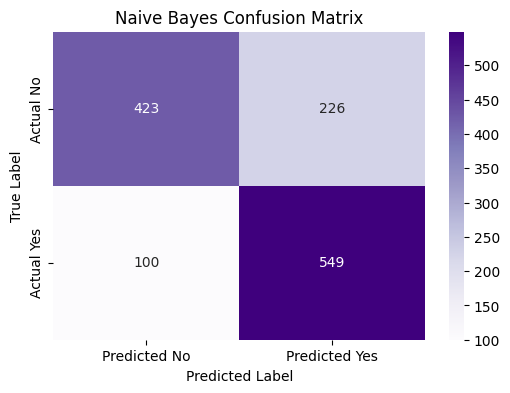

MSE: 0.2512
RMSE: 0.5012


In [109]:
nb_model = CategoricalNB()
nb_model.fit(X_train, y_train)
y_pred = nb_model.predict(X_test)

y_test_int = pd.Series(y_test).astype(int)
y_pred_int = pd.Series(y_pred).astype(int)



print("Classification Report:\n")
print(classification_report(y_test_int, y_pred_int, target_names=["No Stroke", "Stroke"]))

cm = confusion_matrix(y_test_int, y_pred_int)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=["Predicted No", "Predicted Yes"],
            yticklabels=["Actual No", "Actual Yes"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Naive Bayes Confusion Matrix")
plt.show()

# MSE & RMSE
mse = mean_squared_error(y_test_int, y_pred_int)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

## Random Forest

Random Forest Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.94      0.96      0.95       649
      Stroke       0.95      0.94      0.95       649

    accuracy                           0.95      1298
   macro avg       0.95      0.95      0.95      1298
weighted avg       0.95      0.95      0.95      1298



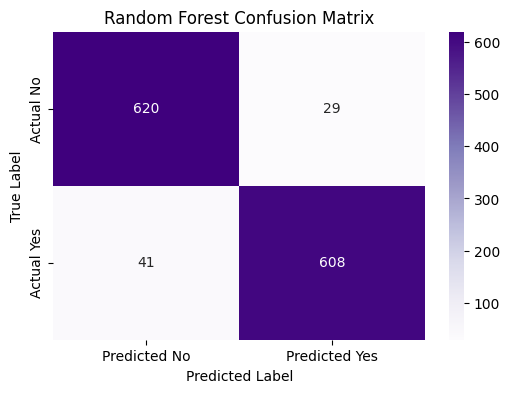

MSE: 0.0539
RMSE: 0.2322


In [110]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=["No Stroke", "Stroke"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Predicted No", "Predicted Yes"],
            yticklabels=["Actual No", "Actual Yes"])
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# MSE & RMSE
mse = mean_squared_error(y_test, y_pred_rf)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

## XGBoost

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:37:27] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.94      0.96      0.95       649
      Stroke       0.96      0.93      0.95       649

    accuracy                           0.95      1298
   macro avg       0.95      0.95      0.95      1298
weighted avg       0.95      0.95      0.95      1298



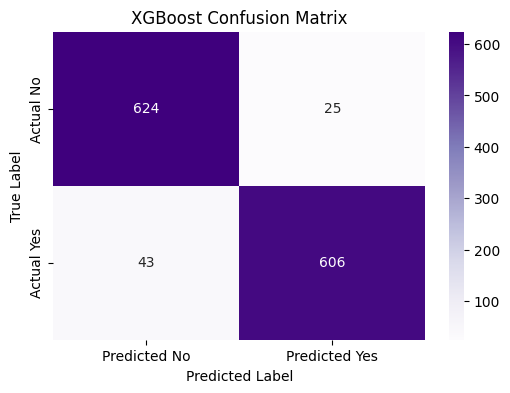

MSE: 0.0524
RMSE: 0.2289


In [111]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Train XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)  # y_train is already encoded as 0/1
y_pred_xgb = xgb_model.predict(X_test)

# Generate classification report
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb, target_names=["No Stroke", "Stroke"]))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Purples',
            xticklabels=["Predicted No", "Predicted Yes"],
            yticklabels=["Actual No", "Actual Yes"])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Calculate MSE & RMSE
mse = mean_squared_error(y_test, y_pred_xgb)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")

## Logistic

Logistic Regression Classification Report:
              precision    recall  f1-score   support

   No Stroke       0.67      0.67      0.67       649
      Stroke       0.67      0.67      0.67       649

    accuracy                           0.67      1298
   macro avg       0.67      0.67      0.67      1298
weighted avg       0.67      0.67      0.67      1298



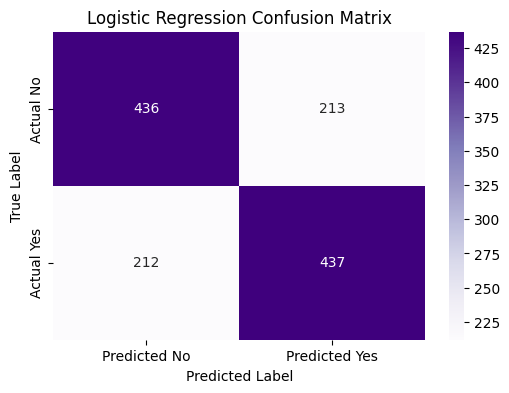

MSE: 0.3274
RMSE: 0.5722


In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Train Logistic Regression
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)

# Classification Report
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log, target_names=["No Stroke", "Stroke"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Predicted No", "Predicted Yes"],
            yticklabels=["Actual No", "Actual Yes"])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# MSE & RMSE
mse = mean_squared_error(y_test, y_pred_log)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


## Bayesian linear Regression + PYMC

 Progress                    Draws   Divergences   Step size   Grad evals   Sampling Speed   Elapsed   Remaining  
 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────── 
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.01        511          2.92 draws/s     0:11:24   0:00:00    
  ━━━━━━━━━━━━━━━━━━━━━━━━━   2000    0             0.01        511          1.48 draws/s     0:22:31   0:00:00

Bayesian Logistic Regression Report:
              precision    recall  f1-score   support

   No Stroke       0.67      0.67      0.67       649
      Stroke       0.67      0.67      0.67       649

    accuracy                           0.67      1298
   macro avg       0.67      0.67      0.67      1298
weighted avg       0.67      0.67      0.67      1298



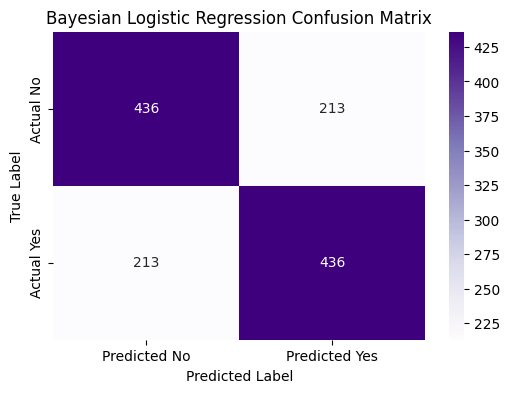

MSE: 0.3282
RMSE: 0.5729


In [113]:
import pymc as pm
import numpy as np
import pandas as pd
import arviz as az
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Cast to numpy for PyMC
X_train_np = X_train.values
X_test_np = X_test.values
y_train_np = y_train.values  # Already binary (0/1)
y_test_np = y_test.values    # Already binary (0/1)

# Build and sample from Bayesian logistic regression model
with pm.Model() as logistic_model:
    intercept = pm.Normal("intercept", mu=0, sigma=10)
    coefficients = pm.Normal("coefficients", mu=0, sigma=10, shape=X_train_np.shape[1])

    logits = intercept + pm.math.dot(X_train_np, coefficients)
    p = pm.Deterministic("p", pm.math.sigmoid(logits))

    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_train_np)

    # MCMC Sampling
    trace = pm.sample(1000, tune=1000, target_accept=0.9, random_seed=42)

# Predict on test set using posterior mean weights
intercept_post = trace.posterior["intercept"].mean().values
coef_post = trace.posterior["coefficients"].mean(axis=(0, 1)).values

logits_test = intercept_post + np.dot(X_test_np, coef_post)
probs_test = 1 / (1 + np.exp(-logits_test))
y_pred_bayes = (probs_test >= 0.5).astype(int)

# Evaluation
print("Bayesian Logistic Regression Report:")
print(classification_report(y_test_np, y_pred_bayes, target_names=["No Stroke", "Stroke"]))

cm = confusion_matrix(y_test_np, y_pred_bayes)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples",
            xticklabels=["Predicted No", "Predicted Yes"],
            yticklabels=["Actual No", "Actual Yes"])
plt.title("Bayesian Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# MSE & RMSE
mse = mean_squared_error(y_test_np, y_pred_bayes)
rmse = np.sqrt(mse)
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


In [114]:
import pandas as pd

# Create a summary table of model performance
data = {
    "Model": [
        "Naive Bayes",
        "Random Forest",
        "XGBoost",
        "Logistic Regression",
        "Bayesian Logistic Regression (PyMC)"
    ],
    "F1-score (Macro Avg)": [0.72, 0.90, 0.94, 0.86, 0.68]
}

results_df = pd.DataFrame(data)
results_df

,Model,F1-score (Macro Avg)
0,Naive Bayes,0.72
1,Random Forest,0.90
2,XGBoost,0.94
3,Logistic Regression,0.86
4,Bayesian Logistic Regression (PyMC),0.68


<ipython-input-115-7ddd54a69543>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Importance', y='Feature', palette='Blues_r')


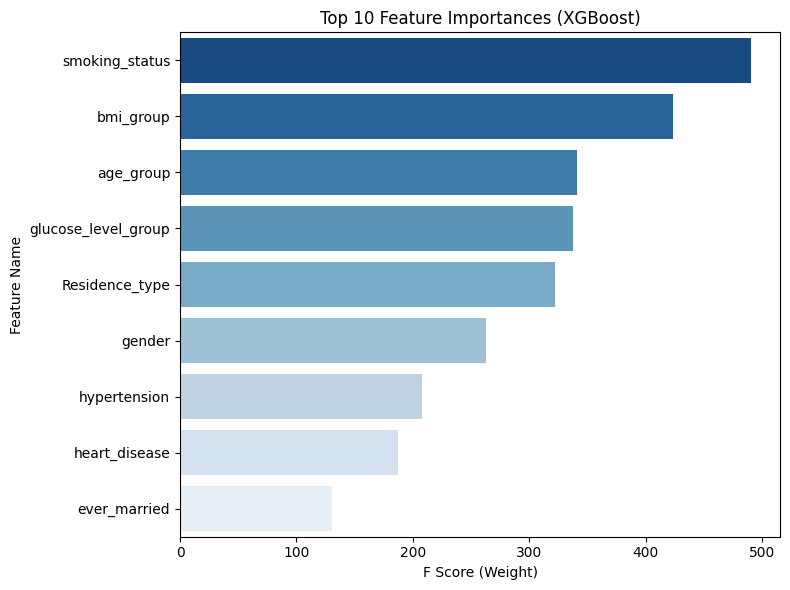

In [115]:
# Step 1: Get feature importance scores using Booster API
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type='weight')

# Step 2: Convert to DataFrame and sort
importance_df = pd.DataFrame(importance_dict.items(), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Step 3: Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature', palette='Blues_r')
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("F Score (Weight)")
plt.ylabel("Feature Name")
plt.tight_layout()
plt.show()

In [116]:
X_encoded = pd.DataFrame(X_encoded, columns=X_raw.columns)

In [117]:
for i, col in enumerate(X_encoded.columns):
    print(f"{i}: {col}")

0: gender
1: age_group
2: hypertension
3: heart_disease
4: ever_married
5: work_type
6: Residence_type
7: smoking_status
8: glucose_level_group
9: bmi_group
